# SCAL Collector

This notebook demonstrates how you can collect measurements and analyze data over development using the ``Collector`` class.

In [1]:
%reload_ext topo.misc.ipython

## Defining the data to be collected

In [2]:
import topo
from topo.analysis import Collector
from topo.submodel.scal import ModelSCAL
from topo.submodel.gcal import ArraySpec
from topo.command import runscript

<center><h3 class='alert alert-info'>Hypercolumn distance estimation requires ``scipy.optimize``</h3></center>

In [3]:
import numpy as np

import pandas
from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix

import imagen

from topo.analysis.command import measure_or_pref
from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis

from topo.analysis.command import measure_or_pref, measure_or_tuning_fullfield, measure_position_pref, measure_response
from topo.command import save_snapshot, load_snapshot

Collector can be configured to collect ``Sheet`` and ``Projection`` activities, ``Projection`` weights, the output of ``featuremapper`` measurements, array data (here the V1 homeostatic threshold) and can be instructed to analyze any of these sources with the ``analyze`` method:

In [4]:
cd ..

/home/philippjfr/topographica/work


In [5]:
from analysis import measure_size_tuning, measure_iso_suppression, measure_flanker_ormodulation, \
    measure_flanker_xoffsetmodulation, measure_flanker_yoffsetmodulation, measure_phase_tuning, \
    ComplexityAnalysis

In [6]:
topo.sim.model = ModelSCAL(cortex_density=47, laterals=False, latexc_strength=0, area=1.5, latexc_size=0.035, lgn_density=16)
scal = topo.sim.model.specification
scal()

In [7]:
c = Collector()

# Projection activities
c.Activity.LGNOnAfferent =  c.collect(scal.projections.V1.LGNOnAfferent)
c.Activity.LGNOffAfferent = c.collect(scal.projections.V1.LGNOffAfferent)

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(scal.sheets.Retina)
c.Activity.V1 =             c.collect(scal.sheets.V1)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(scal.projections.V1.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(scal.projections.V1.LGNOffAfferent, grid=True)
c.CFs.LateralInhibitory =   c.collect(scal.projections.V1.LateralInhibitory, grid=True)
c.CFs.LateralExcitatory =   c.collect(scal.projections.V1.LateralExcitatory, grid=True)

# Homeostatic threshold
c.HomeostaticThreshold.V1 = c.collect(ArraySpec('V1.output_fns[0].t'), 
                                                group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.6])
c.collect(measure_response, durations=list(np.linspace(0,1,21)))

# Spatial Tuning Analysis
#c.collect(measure_position_pref, x_range=(-0.25,0.25), y_range=(-0.25,0.25),
#          size=0.1, outputs=['V1'], divisions=24, scale=2.0)

# Times and coords for further measurements
coords=[(0,-0.1),(-0.1,0.0),(0,0),(0,0.1),(0.1,0.0)]
times=[20000]
frequency=1.6

# Analysis
c.Pinwheels.V1Exc =            c.analyze(c.ref.OrientationPreference.V1
                                         * c.ref.OrientationSelectivity.V1, PinwheelAnalysis)
c.FFTAnalysis.V1Exc =          c.analyze(c.ref.OrientationPreference.V1, PowerSpectrumAnalysis)

In [ ]:
# Orientation Contrast Suppression
c.analyze(c.ref.OrientationPreference.V1, measure_iso_suppression, output='V1',
          frequency=frequency, times=times, mode='merge')

# Size Tuning Analysis
c.analyze(c.ref.OrientationPreference.V1, measure_size_tuning, num_phase=8, outputs=['V1'],
          coords=coords, frequency=frequency, times=times, mode='merge')

# Measure PhaseTuning and Complexity
c.analyze(c.ref.OrientationPreference.V1, measure_phase_tuning, outputs=['V1'], frequencies=[frequency],
          num_orientation=12, times=times, mode='merge')
c.analyze(c.ref.PhaseTuning.V1, ComplexityAnalysis, times=times, mode='merge')

# Measure flanker modulation
c.collect(measure_flanker_ormodulation, coords=coords, outputs=['V1'], times=times)
c.collect(measure_flanker_xoffsetmodulation, coords=coords, outputs=['V1'], times=times)
c.collect(measure_flanker_yoffsetmodulation, coords=coords, outputs=['V1'], times=times)

We will now load the GCAL model:

:HoloMap   [Time]
   :Image   [x,y]   (z)
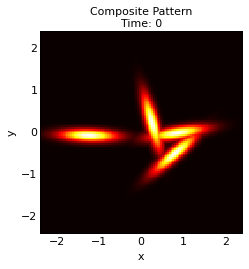
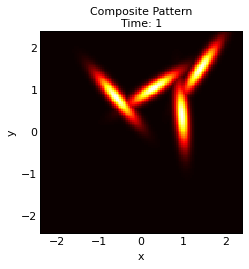
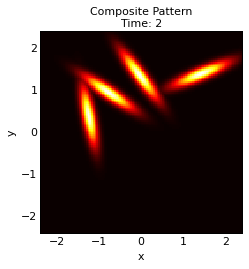
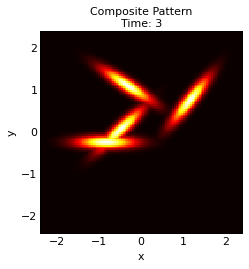
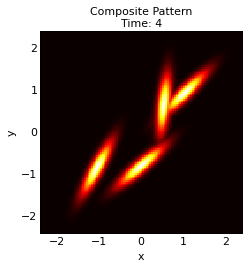
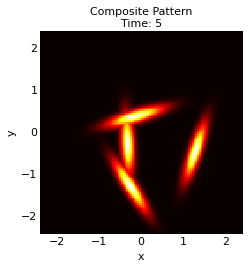
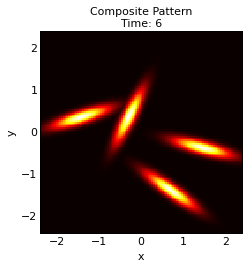
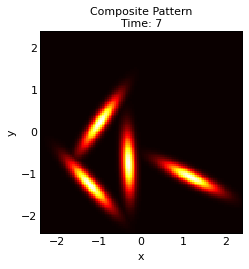
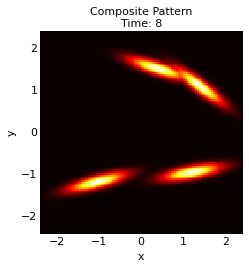
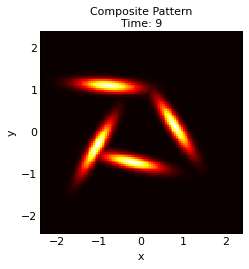
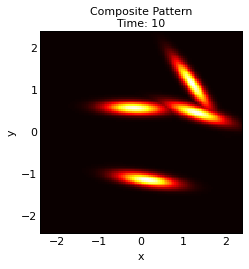
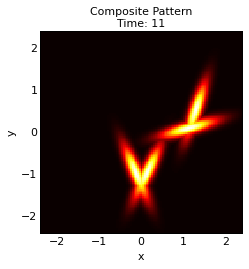

In [8]:
topo.sim.Retina.input_generator.anim(11)

We will run the GCAL model for 15000 iterations, collecting the data defined above every 500 steps:

In [12]:
times = [1000*i for i in range(1, 3)]
print("Collection will start at iteration %d and end on iteration %d" % (min(times), max(times)))

Collection will start at iteration 1000 and end on iteration 2000


In [13]:
data = c(times=times)

Time: 002000.00 PowerSpectrumAnalysis: Slicing data to nearest odd dimensions for centered FFT.


In [12]:
times=[3000, 4000]

:GridSpace   [X,Y]
   :HoloMap   [Time]
      :CFView   [x,y]   (z)
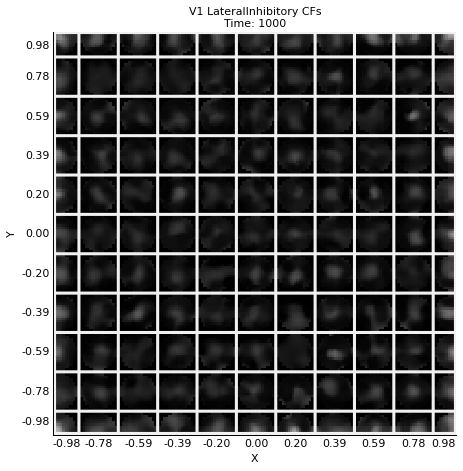
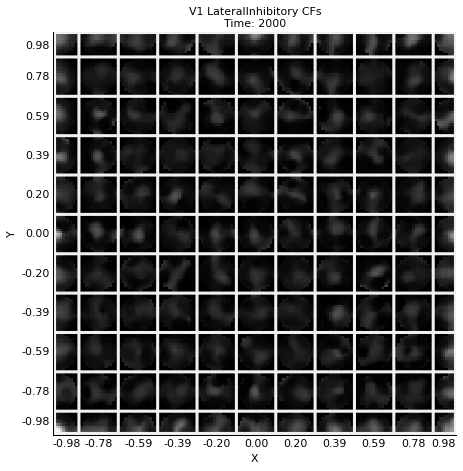
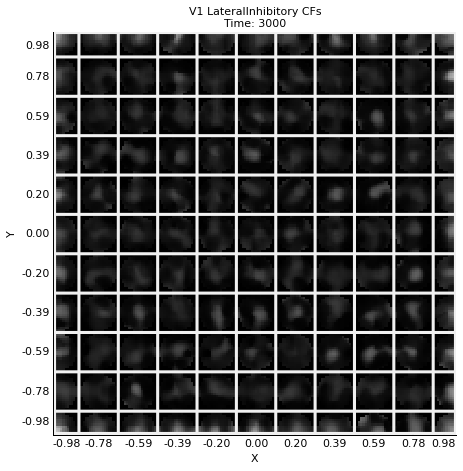

In [18]:
data.CFs.LateralInhibitory

:HoloMap   [Time,Duration]
   :Image   [x,y]   (z)
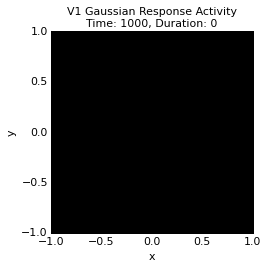
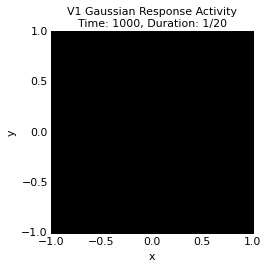
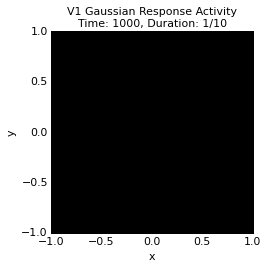
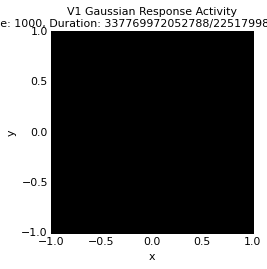
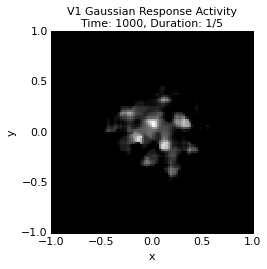
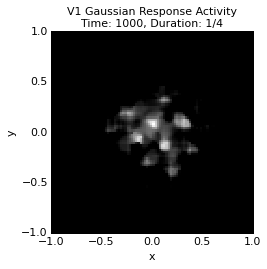
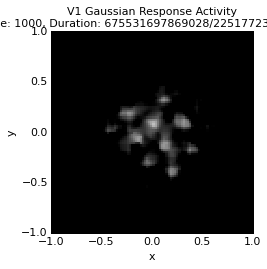
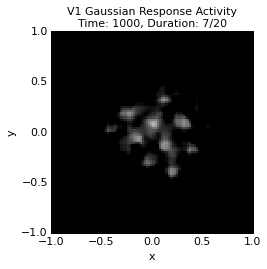
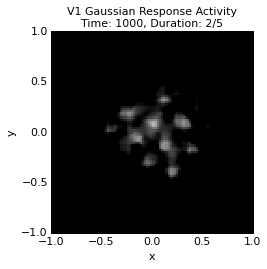
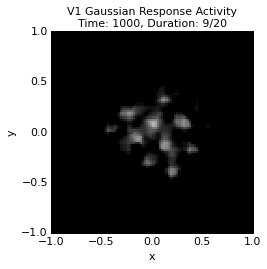
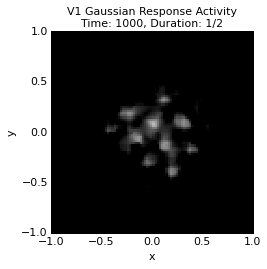
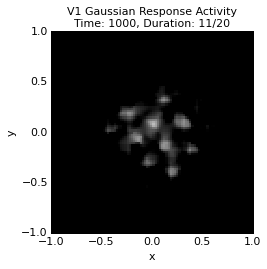
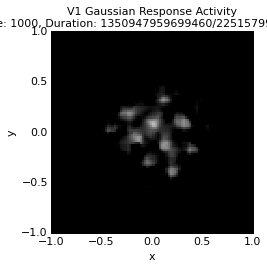
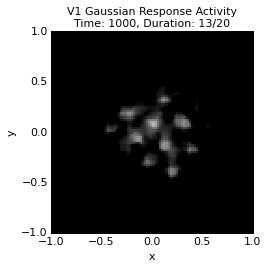
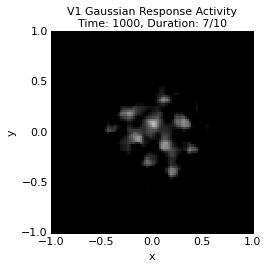
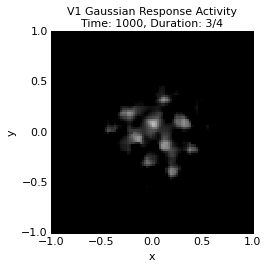
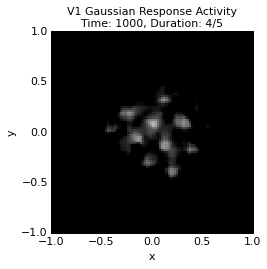
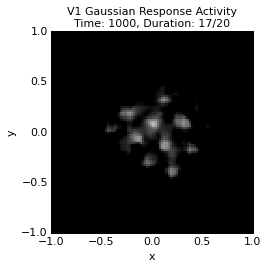
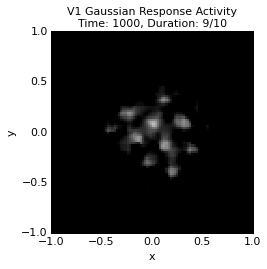
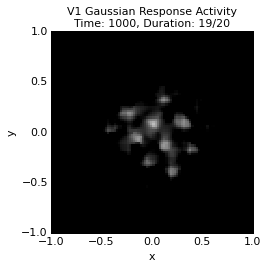
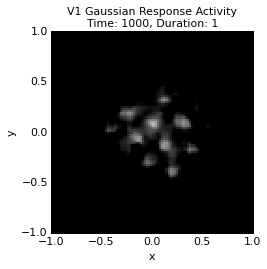
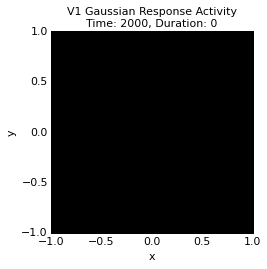
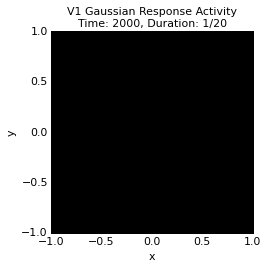
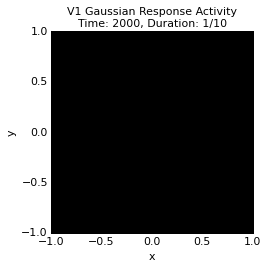
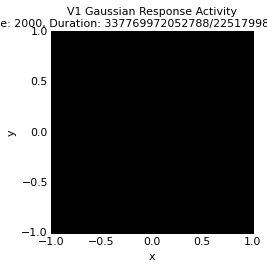
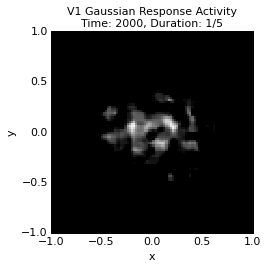
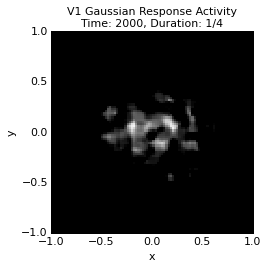
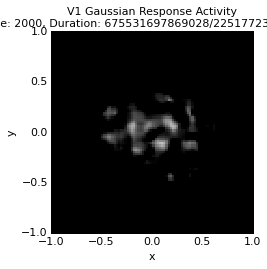
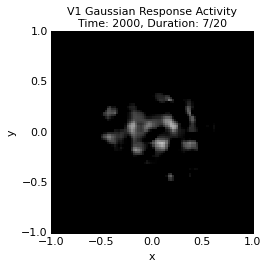
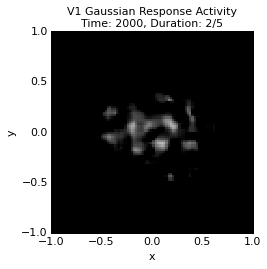
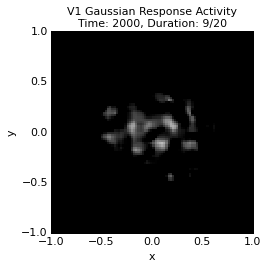
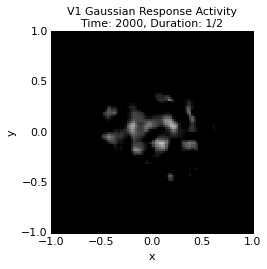
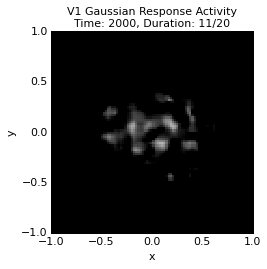
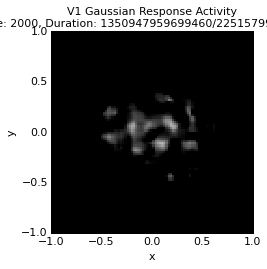
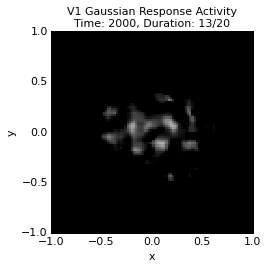
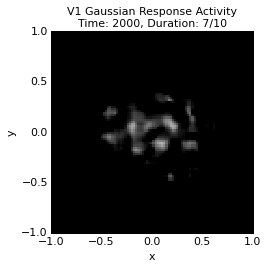
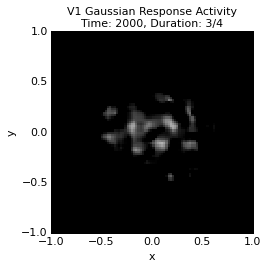
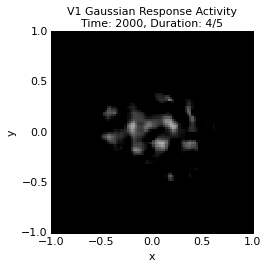
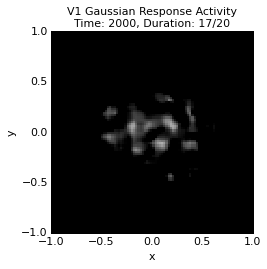
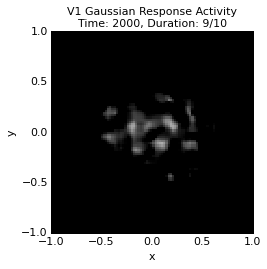
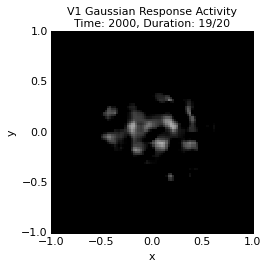
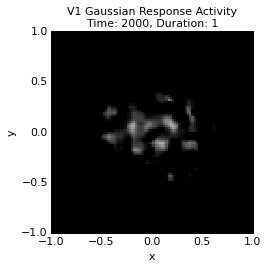
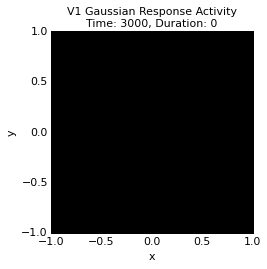
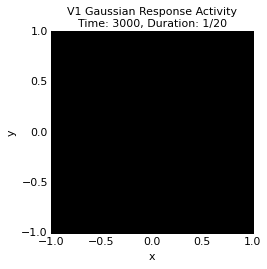
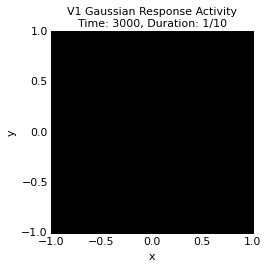
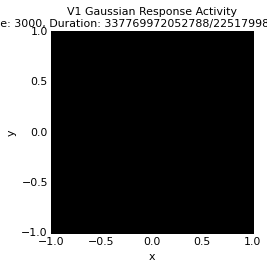
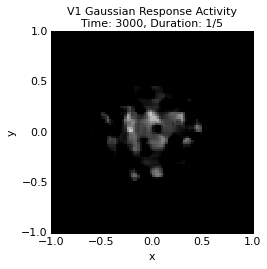
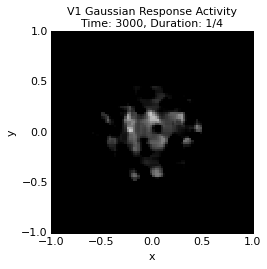
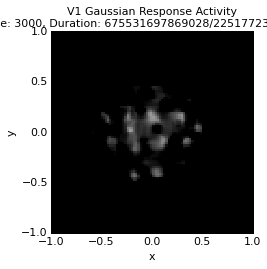
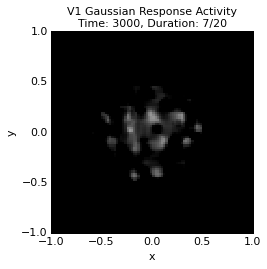
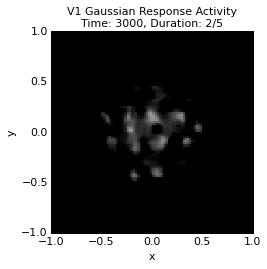
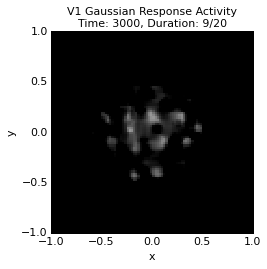
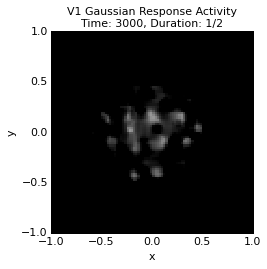
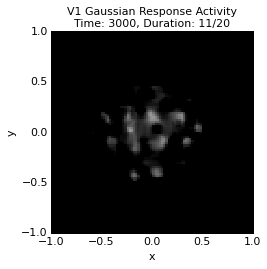
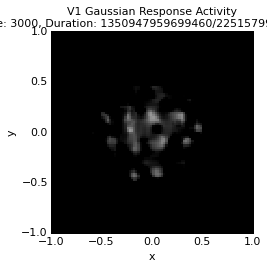
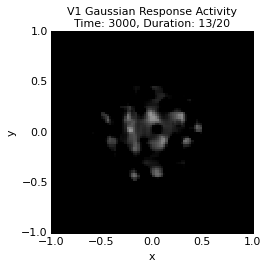
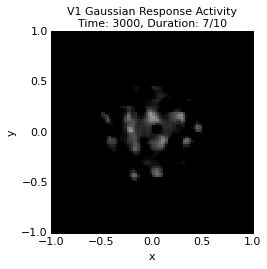
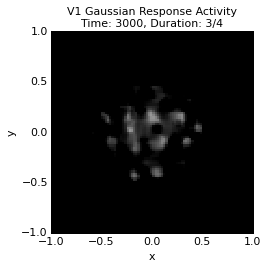
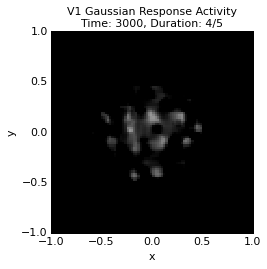
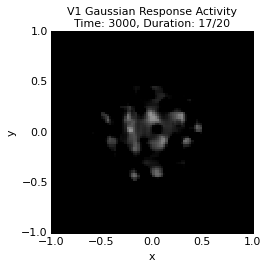
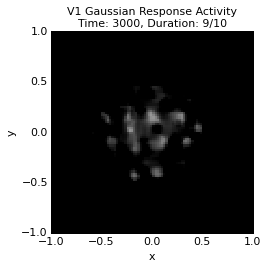
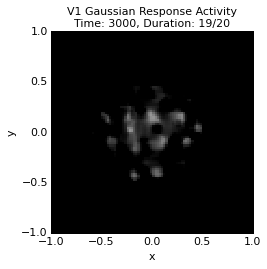
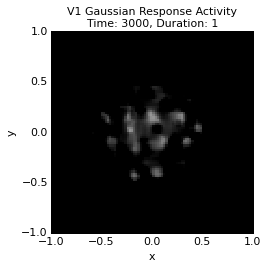

In [17]:
data.GaussianResponse.V1

:HoloMap   [Time,Duration]
   :Overlay
      .Orientation_Preference.V1  :Image   [x,y]   (Orientation Preference)
      .Orientation_Selectivity.V1 :Image   [x,y]   (Orientation Selectivity)
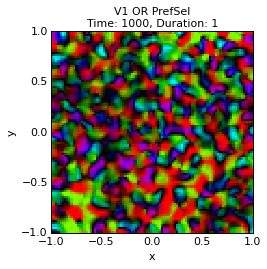
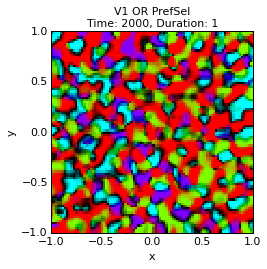

In [14]:
data.OrientationPreference.V1 * data.OrientationSelectivity.V1

In [13]:
data = c(times=times)

Progress:
[                                                                      ] 0.0%Progress:
[                                                                      ] 0.0%
Progress:
[                                                                      ] 0.0%

KeyboardInterrupt: 

In [51]:
topo.sim.run(2500)

In [35]:
topo.sim.time()

mpq(750,1)

:Image   [x,y]   (z)
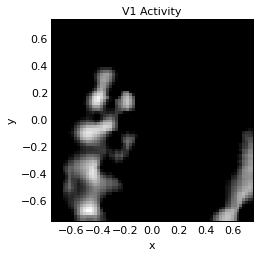

In [52]:
topo.sim.V1[:]

In [17]:
orpref = measure_or_pref(frequencies=[1.7])

Progress:
[                                                                      ] 0.0%Progress:
100% measurement progress 00:00:20

:HoloMap   [Time,Duration]
   :Overlay
      .Orientation_Preference.V1  :Image   [x,y]   (Orientation Preference)
      .Orientation_Selectivity.V1 :Image   [x,y]   (Orientation Selectivity)
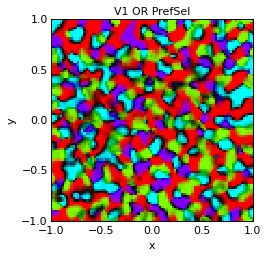

In [18]:
orpref.OrientationPreference.V1 * orpref.OrientationSelectivity.V1

In [22]:
import imagen as ig

In [23]:
import holoviews as hv

In [36]:
responses = hv.HoloMap({c: measure_response(pattern_generator=ig.Gaussian(scale=c),
                                            durations=[0.05*i for i in range(21)])
                        for c in np.linspace(0, 0.7, 11)}, kdims=['Contrast']).collate()

:HoloMap   [Time]
   :NdOverlay   [Contrast]
      :Curve   [Duration]   (z)
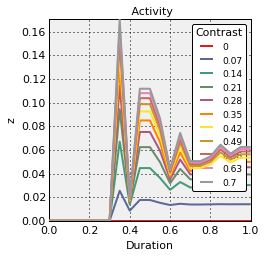

In [38]:
%%opts Curve (color=Palette('Set1'))
responses.GaussianResponse.V1.reduce(x=np.mean, y=np.mean).to.curve(['Duration'], ['z']).overlay('Contrast')

In [55]:
response = measure_response()

:HoloMap   [Time,Duration]
   :Image   [x,y]   (z)
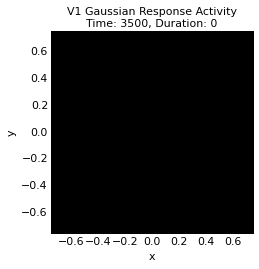
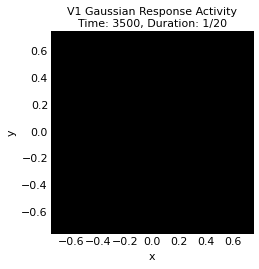
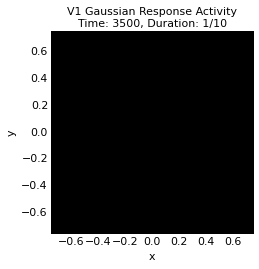
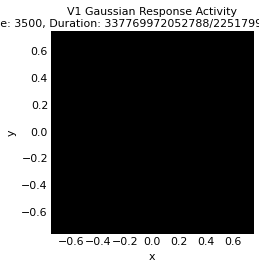
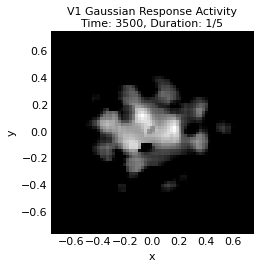
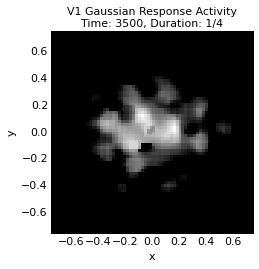
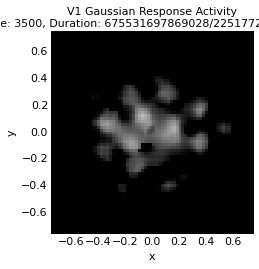
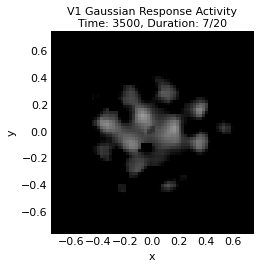
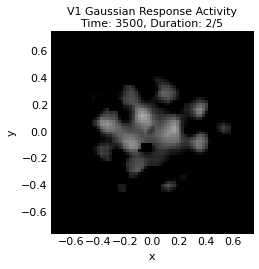
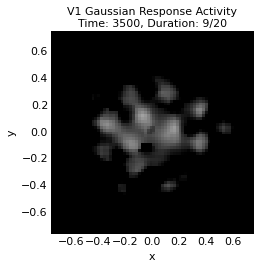
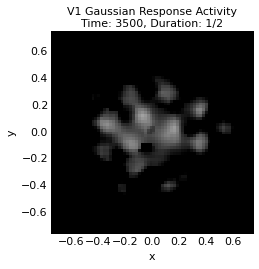
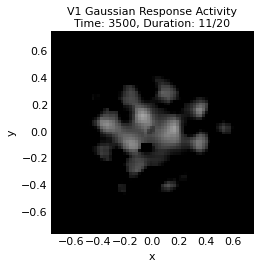
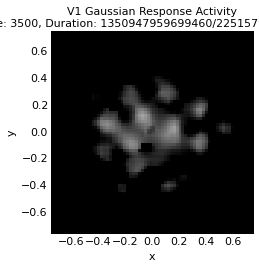
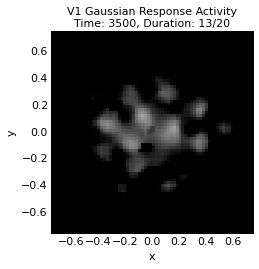
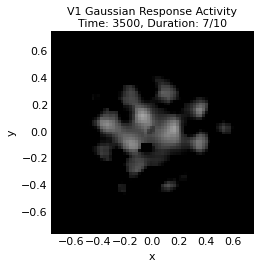
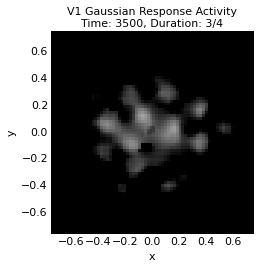
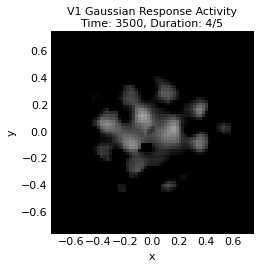
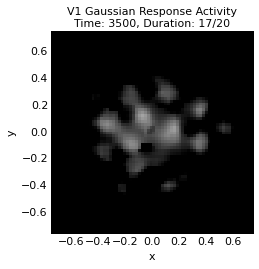
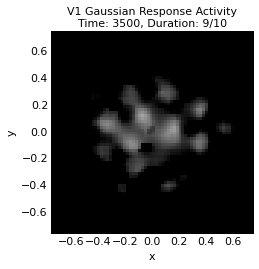
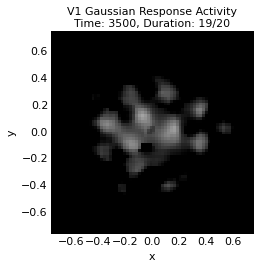
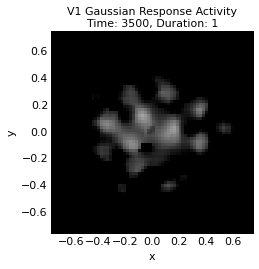

In [56]:
response.GaussianResponse.V1

## Complexity Analysis

In [ ]:
cropped_complexity = data.Complexity.V1[:,:,-0.5:0.5,-0.5:0.5]
cropped_selectivity = data.OrientationSelectivity.V1[:,:,-0.5:0.5,-0.5:0.5]
cropped_phaseselectivity = data.PhaseSelectivity.V1[:,:,-0.5:0.5,-0.5:0.5]
cropped_orpref = data.OrientationPreference.V1[:,:,-0.5:0.5,-0.5:0.5]
cropped_phasepref = data.PhasePreference.V1[:,:,-0.5:0.5,-0.5:0.5]

In [ ]:
%%view png 120
%%opts Complexity_Analysis edgecolor='k'
cropped_complexity + cropped_complexity.hist(bin_range=(0,2.), num_bins=11, adjoin=False)

In [ ]:
data.OrientationPreference.V1.hist()

In [ ]:
print topo.sim.V1.LateralInhibitory.nominal_bounds_template
topo.sim.V1.LateralInhibitory.weights_generator

In [ ]:
topo.sim.V1.LGNOnAfferent.weights_generator

In [ ]:
data.CFs.LateralInhibitory

In [ ]:
data.CFs.LGNOnAfferent

In [ ]:
%%opts Complexity_Analysis [num_ticks=11]
cropped_orpref * cropped_selectivity + \
cropped_phasepref * cropped_phaseselectivity + \
(cropped_complexity.hist(bin_range=(0,2.), num_bins=10))

In [ ]:
cmplx_df = cropped_complexity.grid_sample(48,48).dframe()
sel_df = cropped_selectivity.grid_sample(48,48).dframe()
phasesel_df = cropped_phaseselectivity.grid_sample(48,48).dframe()
complexsel_df = DFrame(sel_df.merge(cmplx_df, on=['Time','Duration','X', 'Y']).merge(phasesel_df, on=['Time','Duration','X', 'Y']))

In [ ]:
%%opts DFrame [plot_type='boxplot']
complexsel_df

In [ ]:
%%view 250
%%opts DFrame [plot_type='scatter_matrix']
complexsel_df

## Flanker modulation analysis

In [ ]:
data.OrientationoffsetTuning.V1

In [ ]:
data.YoffsetTuning.grid()

In [ ]:
data.XoffsetTuning.grid()

In [ ]:
fxm.XoffsetTuning.V1.sample([(0,0)]).collate('XOffset')

In [ ]:
fxm.XoffsetTuning.V1.grid_sample(12,12,lbrt=(-0.125,-0.125,0.125,0.125), collate='XOffset')

In [ ]:
form.OrientationoffsetTuning.V1.grid_sample(12,12,lbrt=(-0.125,-0.125,0.125,0.125), collate='OrientationOffset')

## Orientation Contrast Analysis

In [ ]:
%%opts DFrame [plot_type='hist'] bins=20
data.OCSI_Analysis.V1[:,:,-2:2]

In [ ]:
ocsi_dfv=DFrame(data.OCSI_Analysis.V1.map(lambda v, k: v.apply('describe')).dframe())

In [ ]:
ocsi_dfv.table('OCSI', indices=['mean', 'std'], stack_dims=['Time', 'ContrastSurround'])

In [ ]:
from featuremapper.command import measure_or_tuning

In [ ]:
ortc = measure_or_tuning(outputs=['V1'], size=1.0)

In [ ]:
%%view 
ortc.OrientationTuning.V1.grid_sample(12,12, lbrt=(-0.125,-0.125,0.125,0.125), collate='Orientation')

In [ ]:
data.OrientationContrastResponse.V1

In [ ]:
DFrame(data.OCSI_Analysis.V1.map(lambda v, k: v.apply('describe')).dframe()).table

In [ ]:
%%opts DFrame [plot_type='plot'] style='.' 
data.OCSI_Analysis.V1

## Size Tuning Analysis

In [ ]:
%%view 200
%%opts DFrame [plot_type='scatter_matrix'] diagonal='kde'
data.SizeTuning.V1

In [ ]:
%%view 150
data.SizeTuning.V1.dfview().heatmap(value_dim='Peak_Size', dims=['Time','Contrast'], reduce_fn=np.mean)

In [ ]:
from dataviews.options import options, PlotOpts

In [ ]:
options.Peak_Size_DFrameView = PlotOpts(plot_type='plot')
options.Suppression_Size_DFrameView = PlotOpts(plot_type='plot')
peak_kde = data.SizeTuning.V1.map(lambda v, k: v.clone(v.apply('filter',['Peak_Size']).data, label='Peak_Size'))
supp_kde = data.SizeTuning.V1.map(lambda v, k: v.clone(v.apply('filter',['Suppression_Size']).data, label='Suppression_Size'))

In [ ]:
peak_kde.overlay_dimensions(['Contrast']) + supp_kde.overlay_dimensions(['Contrast'])

In [ ]:
%%opts Peak_Size_DFrame kind='kde' style='r-' Suppression_Size_DFrame kind='kde' style='b--'
peak_kde * supp_kde

In [ ]:
peak_box = data.SizeTuning.V1.map(lambda v,k: v.apply('filter', ['Peak_Size', 'Suppression_Size']))
peak_describe = data.SizeTuning.V1.map(lambda v, k: v.apply('describe')).dfview().table(value_dim='Peak_Size', stack_dims=['Time','Contrast'])
suppression_describe = data.SizeTuning.V1.map(lambda v, k: v.apply('describe')).dfview().table(value_dim='Suppression_Size', stack_dims=['Time','Contrast'])
peak_box + peak_describe + suppression_describe

In [ ]:
%%view 150
%%opts DFrame [plot_type='boxplot' size=(9,9)]
data.SizeTuning.V1 + data.ContrastShift.V1

In [ ]:
topo.sim.data = data
save_snapshot('/home/philippjfr/topographica/work/SCAL/Pandas_Test.typ')

### Sheet and projection activities

Here are both the projection activities (top row) and sheet activies (bottom row)

In [17]:
data.Activity.V1.reduce(X=np.max, Y=np.max).collate('Time')

NameError: name 'data' is not defined

In [ ]:
data.Activity.grid().cols(2)

In [ ]:
data.GaussianResponse.V1.grid(['Duration','Time'])

In [ ]:
grid=data.GaussianResponse.V1.grid_sample(5,5, 'Duration', lbrt=(-0.1,-0.1,0.1,0.1))
grid

In [ ]:
data.GaussianResponse.V1[:,:].sample(X=0,Y=0).collate('Duration').overlay_dimensions(['Time'])

### Connection fields (weights)

Here are the weights on the ON surround and OFF surround RGC+LGN projections:

In [ ]:
%%view scrubber
data.CFs.LGNOnAfferent + data.CFs.LGNOffAfferent + data.CFs.LateralInhibitory

### On minus OFF visualization

Here is a visualization of the OFF weights subtracted from the ON weights:

In [ ]:
on_minus_off = (data.CFs.LGNOnAfferent * data.CFs.LGNOffAfferent)
on_minus_off.title = 'ON-OFF CFs'
on_minus_off

In [ ]:
topo.sim.V1.LateralInhibitory.grid()

In [ ]:
data.OrientationPreference.V1.last[-1:1,-1:1]

### OR map and weights over development

* The central map is an polar, orientation + selectivity orientation map.
* The top histogram shows the distribution of orientation preferences across the map.
* The star markers on the map show the positions from which the ON-OFF weights (on the left) are sampled.
* The left side shows ON-OFF weights projecting to the V1 sheet.

In [ ]:
%view 150

In [ ]:
%%opts Points color='w' marker='*' s=100 edgecolors='k'
cf_column = on_minus_off[0,-0.5:0.5]
annotated_map = (data.OrientationPreference.V1 * data.OrientationSelectivity.V1 * Points(cf_column.keys(), bounds=topo.sim.V1.bounds))
annotated_map << cf_column <<  data.OrientationPreference.V1.hist(adjoin=False)

## Homeostatic threshold

This is a visualization of the homeostatic threshold array (output function on the V1 sheet) over development:

In [ ]:
data.HomeostaticThreshold.V1.hist() + data.HomeostaticThreshold.V1.reduce(X=np.mean, Y=np.mean, label_prefix='Mean').collate('Time')

### Orientation and Phase Preference and Selectivity

This animations shows how preference and selectivity evolve over development:

In [ ]:
%%view 75 scrubber
OR_HCS = data.OrientationPreference.V1 * data.OrientationSelectivity.V1
phase_HCS = data.PhasePreference.V1 * data.PhaseSelectivity.V1
top_row = OR_HCS + data.OrientationPreference.V1.hist() + data.OrientationSelectivity.V1.hist() 
bottom_row =  phase_HCS + data.PhasePreference.V1.hist() + data.PhaseSelectivity.V1.hist()
(top_row + bottom_row).cols(3)

### Pinwheel and hypercolumn analysis

In [ ]:
%view 100

In [ ]:
((data.Pinwheels.V1.hist(index=0) + data.FFTPowerSpectrum.V1) + data.FFTAnalysis.V1).cols(2)

We can collate the values of the pinwheel density over time to see how the pinwheel density changes over development. This graph is shown on the left of the figure below. There is a clear drop to zero at iteration 10000 which we can see is due to a failure of the fitting procedure at this time (shown on the right):

In [ ]:
data.FFTAnalysis.V1[0,1][:,0.2:1.01].sample(['kmax']).collate('Time').overlay_dimensions(['Duration']) + \
data.FFTAnalysis.V1[0,1][:,0.2:1.01].sample(['units_per_hc']).collate('Time').overlay_dimensions(['Duration'])+\
data.FFTAnalysis.V1[0,1][:,0.2:1.01].sample(['rho']).collate('Time').overlay_dimensions(['Duration'])

In [ ]:
similarity_stack = cyclic_similarity_index(data.OrientationPreference.V1*data.OrientationPreference.V1.last)
similarity_stack.reduce(X=np.mean, Y=np.mean).collate('Time').overlay_dimensions(['Duration'])

In [ ]:
data.OrientationSelectivity.V1.reduce(X=np.mean, Y=np.mean, label_prefix='Mean').collate('Time').overlay_dimensions(['Duration'])

In the [GCAL paper](http://www.jneurosci.org/content/33/40/15747.full) ten, high-quality simulations were run over a wide range of contrasts (with the borders trimmed to eliminate edge effects) so that a decent estimate of the pinwheel density could be obtained for the GCAL model as a whole.